In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from matplotlib import rcParams
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.dates as mdates
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

In [2]:
from statsmodels.tsa.arima.model import ARIMA

In [3]:
plt.style.use('ggplot')
rcParams['figure.figsize'] = 12, 5
rcParams['pdf.fonttype'] = 3
rcParams['font.size'] = 8
rcParams['axes.linewidth'] = 1

In [4]:
df = pd.read_csv('./../data/weather_dataset_preprocesado.csv')

# # take only the 50% of the data
# df = df[:int(len(df)//2)]

load = df['T (degC)']
time = df['datetime']
x_label = 'Time'
y_label = 'Temperature (°C)'

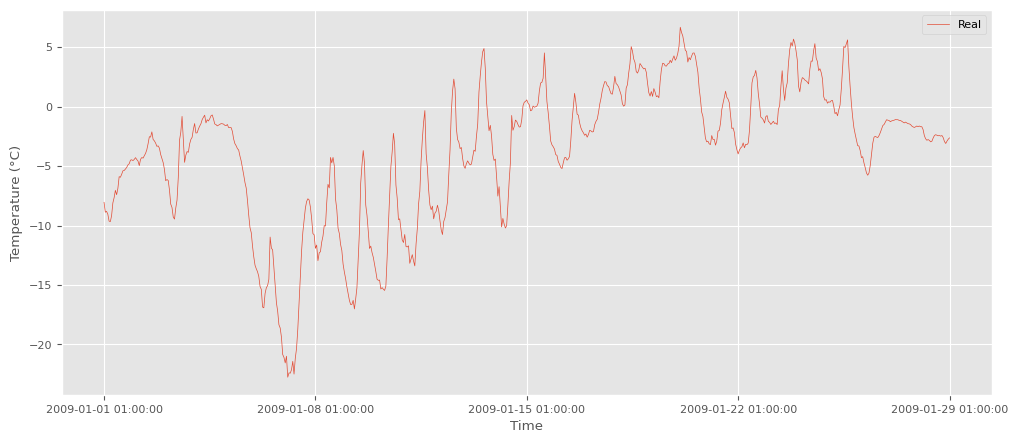

In [5]:
plt.plot(time[:673], load[:673], label='Real', linewidth=0.5)
plt.xticks(np.arange(0, 673, step = 168))
plt.legend()
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.show()

In [6]:
display(load.describe())

count    50224.000000
mean         9.254321
std          8.625312
min        -22.760000
25%          3.140000
50%          9.450000
75%         15.452500
max         35.650000
Name: T (degC), dtype: float64

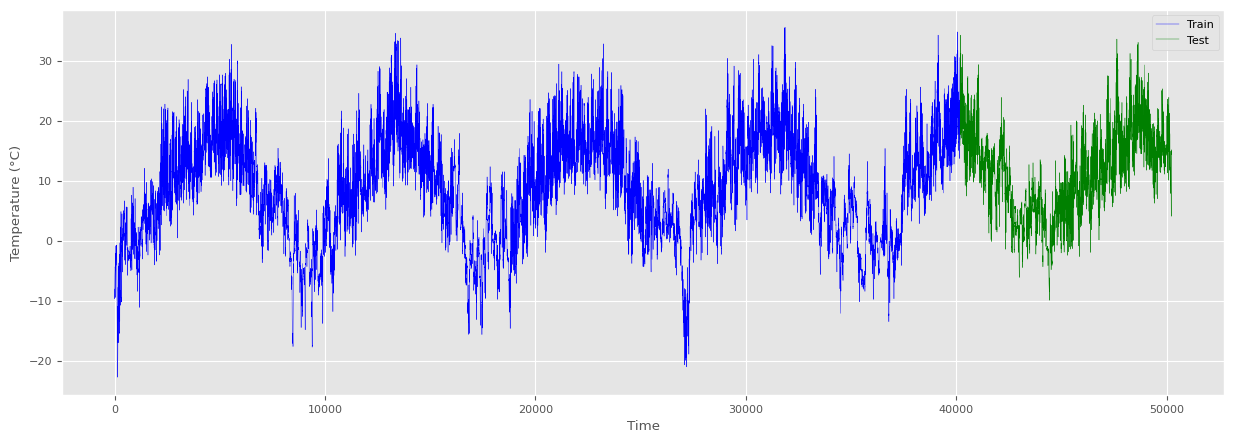

In [7]:
train = load[:int(len(load)*0.8)]
test = load[int(len(load)*0.8):]

plt.figure(figsize=(15, 5))
plt.plot(train, label='Train', color='b', linewidth=0.3)
plt.plot(test, label='Test', color='g', linewidth=0.3)
plt.xlabel(xlabel=x_label)
plt.ylabel(ylabel=y_label)
plt.legend()
plt.show()

<Figure size 1200x500 with 0 Axes>

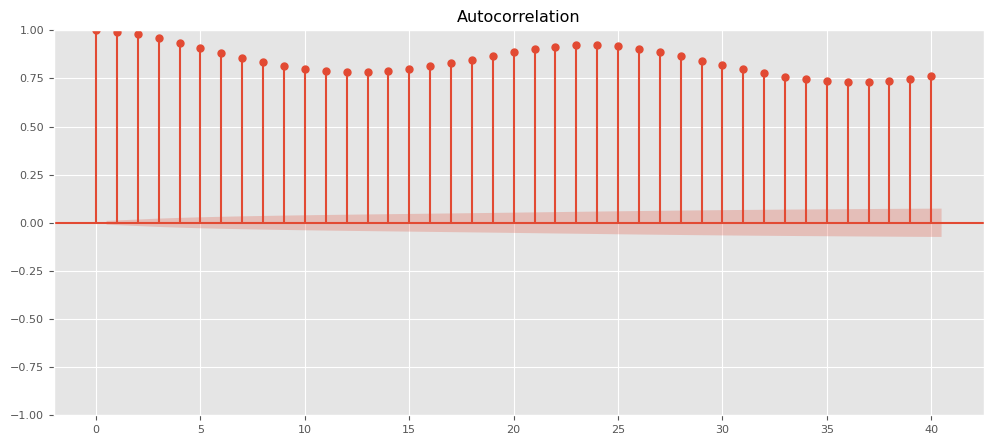

<Figure size 1200x500 with 0 Axes>

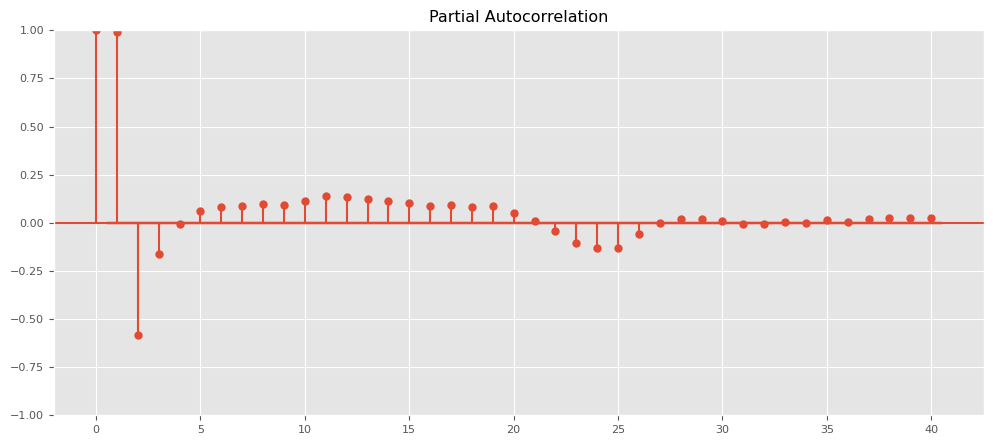

In [8]:
plt.figure()
acf_values = acf(train)
plot_acf(train, lags=40)
plt.show()

plt.figure()
pacf_values = pacf(train)
plot_pacf(train, lags=40)
plt.show()

In [9]:
df_train = pd.DataFrame(train)
df_test = pd.DataFrame(test)
t_degc = 'T (degC)'

for i in range(1,4):
    df_train["lag{}".format(i)] = df_train[t_degc].shift(i)
    df_test["lag{}".format(i)] = df_test[t_degc].shift(i)

df_train = df_train.bfill()
df_train = df_train.drop(columns = [t_degc])
df_test = df_test.bfill()
df_test = df_test.drop(columns = [t_degc])

display(df_train, df_test)

,lag1,lag2,lag3
0,-8.05,-8.05,-8.05
1,-8.05,-8.05,-8.05
2,-8.88,-8.05,-8.05
3,-8.81,-8.88,-8.05
4,-9.05,-8.81,-8.88
...,...,...,...
40174,22.40,23.72,26.45
40175,20.36,22.40,23.72
40176,19.28,20.36,22.40
40177,18.88,19.28,20.36


,lag1,lag2,lag3
40179,15.89,15.89,15.89
40180,15.89,15.89,15.89
40181,16.37,15.89,15.89
40182,18.50,16.37,15.89
40183,21.14,18.50,16.37
...,...,...,...
50219,13.17,10.36,8.01
50220,13.69,13.17,10.36
50221,14.19,13.69,13.17
50222,14.99,14.19,13.69


# Empirical M Decomposition - SVM

In [10]:
!pip install emd

# EEMD

In [11]:
import numpy as np
import pandas as pd
import emd
import random
from sklearn.model_selection import train_test_split

# Función para evaluar el EEMD con diferentes parámetros
def evaluate_eemd(train_data, nensembles, ensemble_noise, sd_thresh):
    imf_eemd = emd.sift.ensemble_sift(
        np.array(train_data), 
        nensembles=nensembles, 
        nprocesses=6,  # Mantienes fijo el número de procesos para optimización de rendimiento
        ensemble_noise=ensemble_noise, 
        imf_opts={'sd_thresh': sd_thresh}
    )
    return imf_eemd

# Función para realizar Random Search
def random_search_eemd(train_data, n_iter=10):
    best_params = None
    best_score = float('-inf')
    
    # Lista de parámetros para explorar
    nensembles_list = np.arange(2, 10)  # Números de 2 a 10 ensembles
    ensemble_noise_list = np.linspace(0.1, 2, 10)  # Valores de ruido de 0.1 a 2
    sd_thresh_list = np.linspace(0.01, 0.5, 10)  # Threshold de desviación estándar

    for i in range(n_iter):
        # Selección aleatoria de parámetros
        nensembles = random.choice(nensembles_list)
        ensemble_noise = random.choice(ensemble_noise_list)
        sd_thresh = random.choice(sd_thresh_list)
        
        # Ejecuta el EEMD con los parámetros seleccionados
        imf_eemd = evaluate_eemd(train_data, nensembles, ensemble_noise, sd_thresh)
        
        # Aquí debes definir una métrica para evaluar la calidad del resultado.
        # En este ejemplo, vamos a utilizar la suma de la varianza de cada IMF (como una métrica de calidad)
        score = np.sum(np.var(imf_eemd, axis=1))

        # Verificar si es el mejor score encontrado
        if score > best_score:
            best_score = score
            best_params = {'nensembles': nensembles, 'ensemble_noise': ensemble_noise, 'sd_thresh': sd_thresh}
        
        print(f"Iteración {i+1}/{n_iter}: score = {score}, parámetros = {best_params}")

    return best_params, best_score

Iteración 1/20: score = 588713.3652036734, parámetros = {'nensembles': 2, 'ensemble_noise': 0.9444444444444444, 'sd_thresh': 0.01}
Iteración 2/20: score = 456935.1383734357, parámetros = {'nensembles': 2, 'ensemble_noise': 0.9444444444444444, 'sd_thresh': 0.01}
Iteración 3/20: score = 504052.40357540053, parámetros = {'nensembles': 2, 'ensemble_noise': 0.9444444444444444, 'sd_thresh': 0.01}
Iteración 4/20: score = 445573.5685417905, parámetros = {'nensembles': 2, 'ensemble_noise': 0.9444444444444444, 'sd_thresh': 0.01}
Iteración 5/20: score = 670043.0087467884, parámetros = {'nensembles': 3, 'ensemble_noise': 1.577777777777778, 'sd_thresh': 0.17333333333333334}
Iteración 6/20: score = 331484.8891246714, parámetros = {'nensembles': 3, 'ensemble_noise': 1.577777777777778, 'sd_thresh': 0.17333333333333334}
Iteración 7/20: score = 386525.03888588166, parámetros = {'nensembles': 3, 'ensemble_noise': 1.577777777777778, 'sd_thresh': 0.17333333333333334}
Iteración 8/20: score = 340515.45014611

,imf_eemd_1,imf_eemd_2,imf_eemd_3,imf_eemd_4,imf_eemd_5,imf_eemd_6,imf_eemd_7,imf_eemd_8,imf_eemd_9,imf_eemd_10
0,-4.748544,0.747751,1.965363,1.186378,-8.074179,2.357128,-1.567220,-1.419330,-11.072223,2.933757
1,11.929461,0.865295,2.047719,0.813621,-7.827335,2.366121,-1.573303,-1.416512,-11.069807,2.934130
2,-3.303508,1.586928,1.834016,0.435820,-7.559213,2.374814,-1.579286,-1.413672,-11.067386,2.934502
3,-11.943572,2.340040,1.391159,0.055986,-7.270738,2.383203,-1.585167,-1.410813,-11.064959,2.934875
4,-4.853341,2.251699,0.819311,-0.320501,-6.962833,2.391280,-1.590946,-1.407934,-11.062525,2.935247
...,...,...,...,...,...,...,...,...,...,...
40174,23.358474,-8.435877,0.414093,3.526814,0.191255,-2.030454,2.900558,1.610350,10.284852,5.238069
40175,15.526540,-6.659744,-1.116380,3.394812,0.204985,-2.025002,2.893150,1.609829,10.284067,5.237691
40176,6.598155,-4.456761,-2.372884,3.240424,0.217513,-2.019051,2.885717,1.609302,10.283279,5.237313
40177,-16.753852,-3.624887,-3.250939,3.067351,0.228854,-2.012585,2.878256,1.608768,10.282487,5.236936


<Axes: xlabel='Time (samples)'>

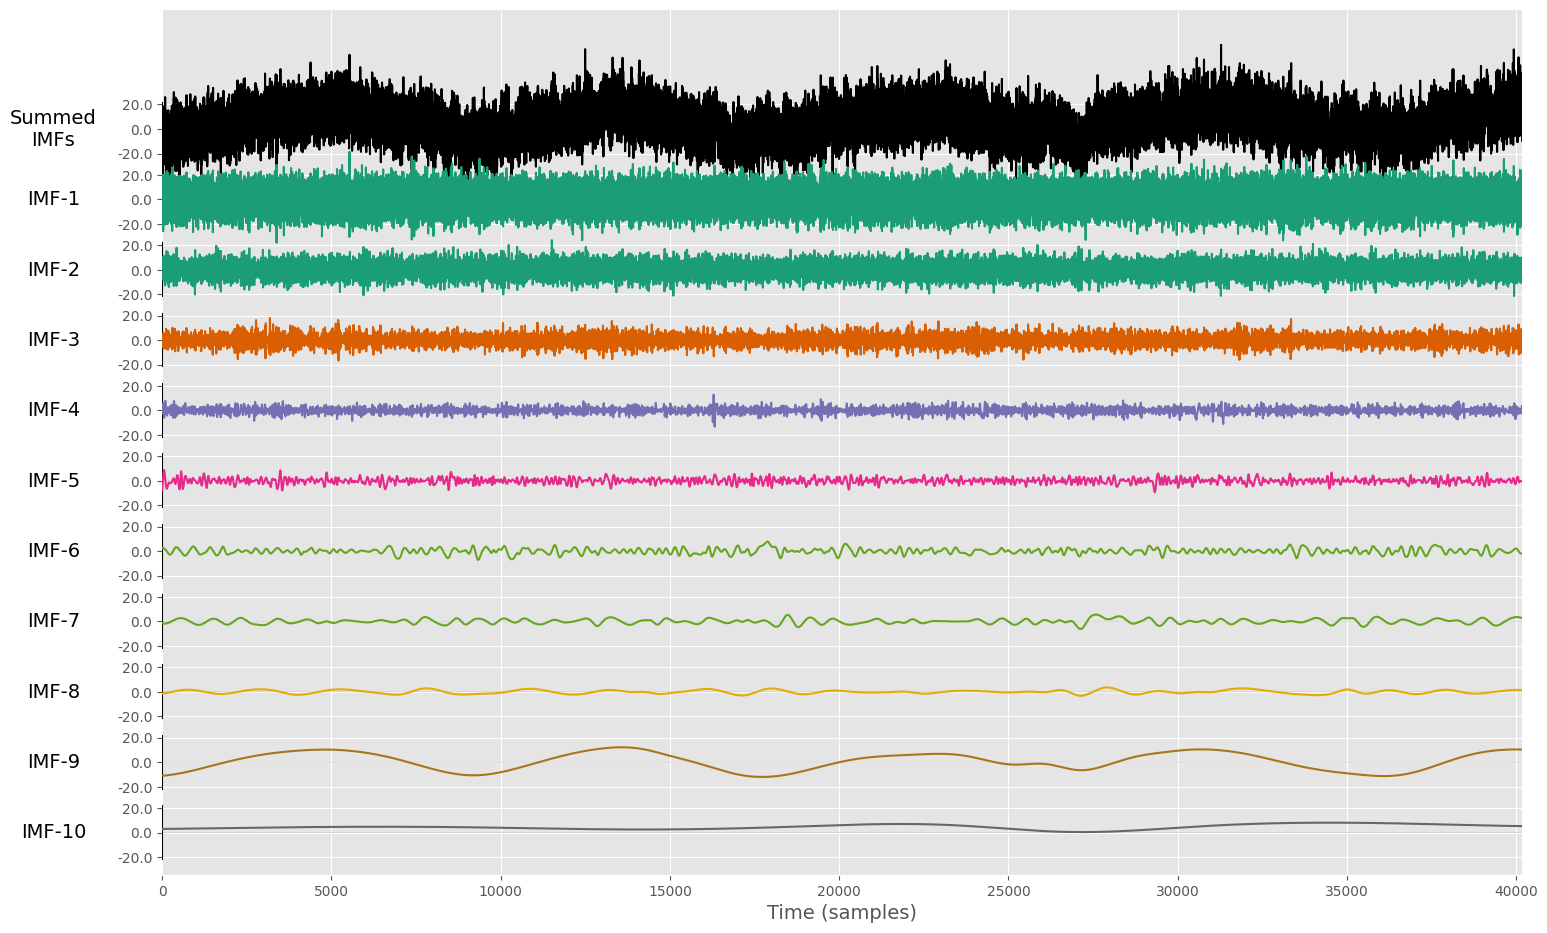

In [12]:
# Ejecuta la búsqueda aleatoria
train_data = np.array(train)  # Asegúrate de tener el array de datos de entrenamiento
best_params, best_score = random_search_eemd(train_data, n_iter=20)

# Usa los mejores parámetros encontrados
print(f"Mejores parámetros encontrados: {best_params} con un score de {best_score}")

# Ejecuta EEMD con los mejores parámetros
imf_eemd = evaluate_eemd(train_data, best_params['nensembles'], best_params['ensemble_noise'], best_params['sd_thresh'])

# Convertir las IMFs a DataFrame
imf_eemd_df = pd.DataFrame(data=imf_eemd)
imf_eemd_df.columns = ['imf_eemd_{}'.format(i + 1) for i in range(0, imf_eemd.shape[1])]
display(imf_eemd_df)

# Visualizar las IMFs
emd.plotting.plot_imfs(imf_eemd)

In [13]:
# import emd

# imf_eemd = emd.sift.ensemble_sift(np.array(train), nensembles=4, nprocesses=6, ensemble_noise=1, imf_opts={'sd_thresh': 0.1})
# emd.plotting.plot_imfs(imf_eemd)

In [14]:
# imf_eemd_df = pd.DataFrame(data = imf_eemd)
# imf_eemd_df.columns = ['imf_eemd_{}'.format(i+1) for i in range(0, imf_eemd.shape[1])]
# display(imf_eemd_df)

In [15]:
def prepare_data(series):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(series.values.reshape(-1, 1))
    
    X, y = [], []
    for i in range(1, len(scaled_data)):
        X.append(scaled_data[i-1:i, 0])
        y.append(scaled_data[i, 0])
        
    return np.array(X), np.array(y), scaler

In [16]:
lstm_1 = 64
dropout = 0.2
lstm_2 = 32
dense_1 = 16
dense_2 = 1

epochs = 8
test_length = len(test)

In [17]:
# IMF 1
imf1_eemd_lstm_X, imf1_eemd_lstm_y, scaler1 = prepare_data(imf_eemd_df['imf_eemd_1'])
imf1_eemd_lstm_X = imf1_eemd_lstm_X.reshape((imf1_eemd_lstm_X.shape[0], 1, imf1_eemd_lstm_X.shape[1]))

model1 = Sequential()
model1.add(LSTM(lstm_1, activation='relu', return_sequences=True, input_shape=(imf1_eemd_lstm_X.shape[1], imf1_eemd_lstm_X.shape[2])))
model1.add(Dropout(dropout))
model1.add(LSTM(lstm_2, activation='relu', return_sequences=False))
model1.add(Dense(dense_1, activation='relu'))
model1.add(Dense(dense_2))
model1.compile(optimizer='adam', loss='mse')
model1.fit(imf1_eemd_lstm_X, imf1_eemd_lstm_y, epochs=epochs, verbose=0)
imf1_eemd_lstm_fc = model1.predict(imf1_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
imf1_eemd_lstm_fc = scaler1.inverse_transform(imf1_eemd_lstm_fc)

# IMF 2
imf2_eemd_lstm_X, imf2_eemd_lstm_y, scaler2 = prepare_data(imf_eemd_df['imf_eemd_2'])
imf2_eemd_lstm_X = imf2_eemd_lstm_X.reshape((imf2_eemd_lstm_X.shape[0], 1, imf2_eemd_lstm_X.shape[1]))

model2 = Sequential()
model2.add(LSTM(lstm_1, activation='relu', return_sequences=True, input_shape=(imf2_eemd_lstm_X.shape[1], imf2_eemd_lstm_X.shape[2])))
model2.add(Dropout(dropout))
model2.add(LSTM(lstm_2, activation='relu', return_sequences=False))
model2.add(Dense(dense_1, activation='relu'))
model2.add(Dense(dense_2))
model2.compile(optimizer='adam', loss='mse')
model2.fit(imf2_eemd_lstm_X, imf2_eemd_lstm_y, epochs=epochs, verbose=0)
imf2_eemd_lstm_fc = model2.predict(imf2_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
imf2_eemd_lstm_fc = scaler2.inverse_transform(imf2_eemd_lstm_fc)

# IMF 3
imf3_eemd_lstm_X, imf3_eemd_lstm_y, scaler3 = prepare_data(imf_eemd_df['imf_eemd_3'])
imf3_eemd_lstm_X = imf3_eemd_lstm_X.reshape((imf3_eemd_lstm_X.shape[0], 1, imf3_eemd_lstm_X.shape[1]))

model3 = Sequential()
model3.add(LSTM(lstm_1, activation='relu', return_sequences=True, input_shape=(imf3_eemd_lstm_X.shape[1], imf3_eemd_lstm_X.shape[2])))
model3.add(Dropout(dropout))
model3.add(LSTM(lstm_2, activation='relu', return_sequences=False))
model3.add(Dense(dense_1, activation='relu'))
model3.add(Dense(dense_2))
model3.compile(optimizer='adam', loss='mse')
model3.fit(imf3_eemd_lstm_X, imf3_eemd_lstm_y, epochs=epochs, verbose=0)
imf3_eemd_lstm_fc = model3.predict(imf3_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
imf3_eemd_lstm_fc = scaler3.inverse_transform(imf3_eemd_lstm_fc)

# IMF 4
imf4_eemd_lstm_X, imf4_eemd_lstm_y, scaler4 = prepare_data(imf_eemd_df['imf_eemd_4'])
imf4_eemd_lstm_X = imf4_eemd_lstm_X.reshape((imf4_eemd_lstm_X.shape[0], 1, imf4_eemd_lstm_X.shape[1]))

model4 = Sequential()
model4.add(LSTM(lstm_1, activation='relu', return_sequences=True, input_shape=(imf4_eemd_lstm_X.shape[1], imf4_eemd_lstm_X.shape[2])))
model4.add(Dropout(dropout))
model4.add(LSTM(lstm_2, activation='relu', return_sequences=False))
model4.add(Dense(dense_1, activation='relu'))
model4.add(Dense(dense_2))
model4.compile(optimizer='adam', loss='mse')
model4.fit(imf4_eemd_lstm_X, imf4_eemd_lstm_y, epochs=epochs, verbose=0)
imf4_eemd_lstm_fc = model4.predict(imf4_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
imf4_eemd_lstm_fc = scaler4.inverse_transform(imf4_eemd_lstm_fc)

# IMF 5
imf5_eemd_lstm_X, imf5_eemd_lstm_y, scaler5 = prepare_data(imf_eemd_df['imf_eemd_5'])
imf5_eemd_lstm_X = imf5_eemd_lstm_X.reshape((imf5_eemd_lstm_X.shape[0], 1, imf5_eemd_lstm_X.shape[1]))

model5 = Sequential()
model5.add(LSTM(lstm_1, activation='relu', return_sequences=True, input_shape=(imf5_eemd_lstm_X.shape[1], imf5_eemd_lstm_X.shape[2])))
model5.add(Dropout(dropout))
model5.add(LSTM(lstm_2, activation='relu', return_sequences=False))
model5.add(Dense(dense_1, activation='relu'))
model5.add(Dense(dense_2))
model5.compile(optimizer='adam', loss='mse')
model5.fit(imf5_eemd_lstm_X, imf5_eemd_lstm_y, epochs=epochs, verbose=0)
imf5_eemd_lstm_fc = model5.predict(imf5_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
imf5_eemd_lstm_fc = scaler5.inverse_transform(imf5_eemd_lstm_fc)

# IMF 6
imf6_eemd_lstm_X, imf6_eemd_lstm_y, scaler6 = prepare_data(imf_eemd_df['imf_eemd_6'])
imf6_eemd_lstm_X = imf6_eemd_lstm_X.reshape((imf6_eemd_lstm_X.shape[0], 1, imf6_eemd_lstm_X.shape[1]))

model6 = Sequential()
model6.add(LSTM(lstm_1, activation='relu', return_sequences=True, input_shape=(imf6_eemd_lstm_X.shape[1], imf6_eemd_lstm_X.shape[2])))
model6.add(Dropout(dropout))
model6.add(LSTM(lstm_2, activation='relu', return_sequences=False))
model6.add(Dense(dense_1, activation='relu'))
model6.add(Dense(dense_2))
model6.compile(optimizer='adam', loss='mse')
model6.fit(imf6_eemd_lstm_X, imf6_eemd_lstm_y, epochs=epochs, verbose=0)
imf6_eemd_lstm_fc = model6.predict(imf6_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
imf6_eemd_lstm_fc = scaler6.inverse_transform(imf6_eemd_lstm_fc)

# IMF 7
imf7_eemd_lstm_X, imf7_eemd_lstm_y, scaler7 = prepare_data(imf_eemd_df['imf_eemd_7'])
imf7_eemd_lstm_X = imf7_eemd_lstm_X.reshape((imf7_eemd_lstm_X.shape[0], 1, imf7_eemd_lstm_X.shape[1]))

model7 = Sequential()
model7.add(LSTM(lstm_1, activation='relu', return_sequences=True, input_shape=(imf7_eemd_lstm_X.shape[1], imf7_eemd_lstm_X.shape[2])))
model7.add(Dropout(dropout))
model7.add(LSTM(lstm_2, activation='relu', return_sequences=False))
model7.add(Dense(dense_1, activation='relu'))
model7.add(Dense(dense_2))
model7.compile(optimizer='adam', loss='mse')
model7.fit(imf7_eemd_lstm_X, imf7_eemd_lstm_y, epochs=epochs, verbose=0)
imf7_eemd_lstm_fc = model7.predict(imf7_eemd_lstm_X[-len(test):].reshape((len(test), 1, 1)))
imf7_eemd_lstm_fc = scaler7.inverse_transform(imf7_eemd_lstm_fc)

c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [18]:
imf8_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_8'], order=(1, 1, 0)).fit()
imf8_eemd_arima_fc = imf8_eemd_arima.forecast(steps=len(test))

imf9_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_9'], order=(1, 1, 0)).fit()
imf9_eemd_arima_fc = imf9_eemd_arima.forecast(steps=len(test))

imf10_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_10'], order=(1, 1, 0)).fit()
imf10_eemd_arima_fc = imf10_eemd_arima.forecast(steps=len(test))

c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [19]:
imf1_eemd_lstm_fc_1 = imf1_eemd_lstm_fc.reshape(-1)
imf2_eemd_lstm_fc_2 = imf2_eemd_lstm_fc.reshape(-1)
imf3_eemd_lstm_fc_3 = imf3_eemd_lstm_fc.reshape(-1)
imf4_eemd_lstm_fc_4 = imf4_eemd_lstm_fc.reshape(-1)
imf5_eemd_lstm_fc_5 = imf5_eemd_lstm_fc.reshape(-1)
imf6_eemd_lstm_fc_6 = imf6_eemd_lstm_fc.reshape(-1)
imf7_eemd_lstm_fc_7 = imf7_eemd_lstm_fc.reshape(-1)

# Sumar las predicciones
imf_eemd_fc = np.sum([
    imf1_eemd_lstm_fc_1, imf2_eemd_lstm_fc_2, imf3_eemd_lstm_fc_3,
    imf4_eemd_lstm_fc_4, imf5_eemd_lstm_fc_5, imf6_eemd_lstm_fc_6, imf7_eemd_lstm_fc_7,
    imf8_eemd_arima_fc, imf9_eemd_arima_fc, imf10_eemd_arima_fc
], axis=0)

# # Imprime la forma final para verificar
# print(imf_lstm_fc.shape)

In [20]:
# # Sumar las predicciones de todos los IMF
# imf_eemd_fc = np.sum([imf1_eemd_lstm_fc, imf2_eemd_lstm_fc, imf3_eemd_lstm_fc, imf4_eemd_lstm_fc, imf5_eemd_lstm_fc,
#                       imf6_eemd_lstm_fc, imf7_eemd_lstm_fc, imf8_eemd_arima_fc, imf9_eemd_arima_fc, imf10_eemd_arima_fc], axis=0)

In [21]:
# import matplotlib.dates as mdates
# import pandas as pd

# target_index = 'datetime'
# df[target_index] = pd.to_datetime(df[target_index])
# df.set_index(target_index, inplace=True)

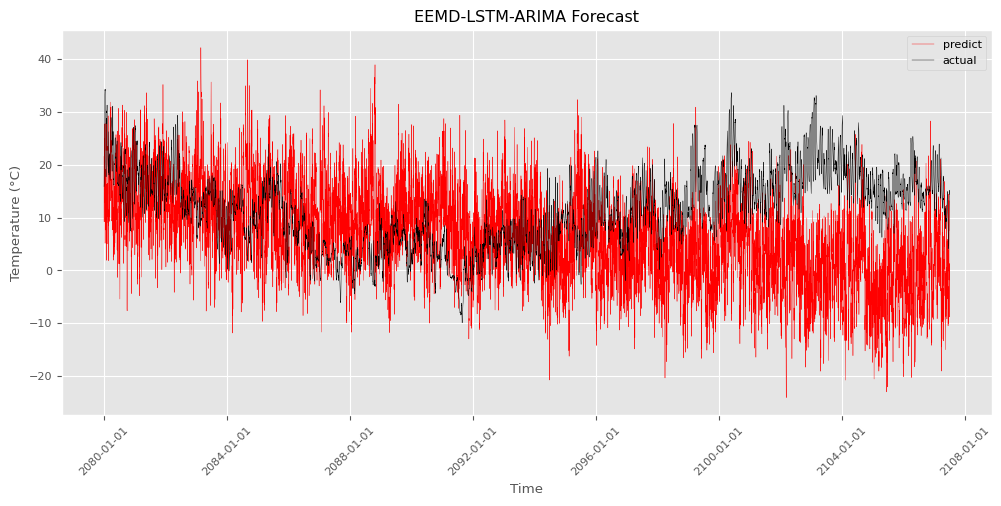

In [22]:
train = load[:int(len(load) * 0.8)]
test = load[int(len(load) * 0.8):]

train.index = df.index[:int(len(load) * 0.8)]
test.index = df.index[int(len(load) * 0.8):]

x_label = 'Time'
y_label = 'Temperature (°C)'

plt.figure(figsize=(12, 5))
plt.plot(test.index, imf_eemd_fc, label='predict', color='r', linewidth=0.3)
plt.plot(test.index, test.values, label='actual', color='k', linewidth=0.3)
plt.xlabel(xlabel=x_label)
plt.ylabel(ylabel=y_label)
plt.title('EEMD-LSTM-ARIMA Forecast')
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.show()

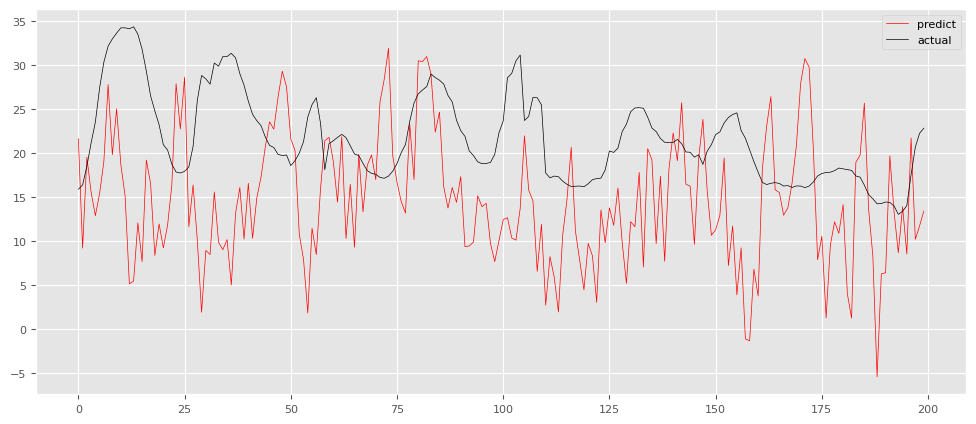

In [23]:
plt.plot(imf_eemd_fc[:200], label = 'predict', color = 'r', linewidth = 0.5)
plt.plot(test[:200].values, label = 'actual', color = 'k', linewidth = 0.5)
plt.legend()
plt.show()

In [24]:
RMSE_EEMD_SVR = mean_squared_error(test, imf_eemd_fc)
MAE_EEMD_SVR  =mean_absolute_error(test, imf_eemd_fc)
MAPE_EEMD_SVR = mean_absolute_percentage_error(test, imf_eemd_fc)
print('MSE = {}'.format(RMSE_EEMD_SVR), '\nMAE = {}'.format(MAE_EEMD_SVR), '\nMAPE = {}'.format(MAPE_EEMD_SVR))

MSE = 182.10436703526958 
MAE = 10.776942728257783 
MAPE = 11591271252064.076


In [25]:
imf1_eemd_lstm_fc_train = model1.predict(imf1_eemd_lstm_X).reshape(-1, 1)
imf1_eemd_lstm_fc_train = scaler1.inverse_transform(imf1_eemd_lstm_fc_train)

imf2_eemd_lstm_fc_train = model2.predict(imf2_eemd_lstm_X).reshape(-1, 1)
imf2_eemd_lstm_fc_train = scaler2.inverse_transform(imf2_eemd_lstm_fc_train)

imf3_eemd_lstm_fc_train = model3.predict(imf3_eemd_lstm_X).reshape(-1, 1)
imf3_eemd_lstm_fc_train = scaler3.inverse_transform(imf3_eemd_lstm_fc_train)

imf4_eemd_lstm_fc_train = model4.predict(imf4_eemd_lstm_X).reshape(-1, 1)
imf4_eemd_lstm_fc_train = scaler4.inverse_transform(imf4_eemd_lstm_fc_train)

imf5_eemd_lstm_fc_train = model5.predict(imf5_eemd_lstm_X).reshape(-1, 1)
imf5_eemd_lstm_fc_train = scaler5.inverse_transform(imf5_eemd_lstm_fc_train)

imf6_eemd_lstm_fc_train = model6.predict(imf6_eemd_lstm_X).reshape(-1, 1)
imf6_eemd_lstm_fc_train = scaler6.inverse_transform(imf6_eemd_lstm_fc_train)

imf7_eemd_lstm_fc_train = model7.predict(imf7_eemd_lstm_X).reshape(-1, 1)
imf7_eemd_lstm_fc_train = scaler7.inverse_transform(imf7_eemd_lstm_fc_train)

1256/1256 ━━━━━━━━━━━━━━━━━━━━ 1s 860us/step
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 1s 875us/step
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 1s 871us/step
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 1s 814us/step
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 1s 826us/step
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1256/1256 ━━━━━━━━━━━━━━━━━━━━ 1s 969us/step


In [26]:
imf8_eemd_arima_fc_train = imf8_eemd_arima.forecast(steps=len(train))
imf9_eemd_arima_fc_train = imf9_eemd_arima.forecast(steps=len(train))
imf10_eemd_arima_fc_train = imf10_eemd_arima.forecast(steps=len(train))

In [27]:
imf10_eemd_arima_fc_train.shape

(40179,)

In [28]:
imf1_eemd_lstm_fc_train_1 = imf1_eemd_lstm_fc_train.reshape(-1)
imf2_eemd_lstm_fc_train_2 = imf2_eemd_lstm_fc_train.reshape(-1)
imf3_eemd_lstm_fc_train_3 = imf3_eemd_lstm_fc_train.reshape(-1)
imf4_eemd_lstm_fc_train_4 = imf4_eemd_lstm_fc_train.reshape(-1)
imf5_eemd_lstm_fc_train_5 = imf5_eemd_lstm_fc_train.reshape(-1)
imf6_eemd_lstm_fc_train_6 = imf6_eemd_lstm_fc_train.reshape(-1)
imf7_eemd_lstm_fc_train_7 = imf7_eemd_lstm_fc_train.reshape(-1)

In [29]:
imf8_eemd_arima_fc_train = imf8_eemd_arima_fc_train[1:]
imf9_eemd_arima_fc_train = imf9_eemd_arima_fc_train[1:]
imf10_eemd_arima_fc_train = imf10_eemd_arima_fc_train[1:]

In [30]:
# Sumar las predicciones
imf_eemd_fc_train = np.sum([
    imf1_eemd_lstm_fc_train_1, imf2_eemd_lstm_fc_train_2, imf3_eemd_lstm_fc_train_3,
    imf4_eemd_lstm_fc_train_4, imf5_eemd_lstm_fc_train_5, imf6_eemd_lstm_fc_train_6, imf7_eemd_lstm_fc_train_7,
    imf8_eemd_arima_fc_train, imf9_eemd_arima_fc_train, imf10_eemd_arima_fc_train
], axis=0)

In [31]:
# imf_eemd_fc_train = np.sum([imf1_eemd_lstm_fc_train, imf2_eemd_lstm_fc_train,
#                             imf3_eemd_lstm_fc_train, imf4_eemd_lstm_fc_train,
#                             imf5_eemd_lstm_fc_train, imf6_eemd_lstm_fc_train,
#                             imf7_eemd_lstm_fc_train, imf8_eemd_arima_fc_train,
#                             imf9_eemd_arima_fc_train, imf10_eemd_arima_fc_train], axis=0)

In [32]:
# deuda tecnica
train_1 = train[1:]

In [33]:
from scipy.optimize import minimize

def dummy1(c):
    global train_1
    global imf_eemd_fc_train
    return mean_squared_error(train_1, imf_eemd_fc_train + c)

res1 = minimize(dummy1, 0, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True})
print(res1.x)

Optimization terminated successfully.
         Current function value: 443.362543
         Iterations: 47
         Function evaluations: 100
[25.97148047]


In [34]:
RMSE_EEMD_SVR = mean_squared_error(train_1, imf_eemd_fc_train + res1.x[0])
MAE_EEMD_SVR  =mean_absolute_error(train_1, imf_eemd_fc_train + res1.x[0])
MAPE_EEMD_SVR = mean_absolute_percentage_error(train_1, imf_eemd_fc_train + res1.x[0])

print('RMSE = {}'.format(RMSE_EEMD_SVR), '\nMAE = {}'.format(MAE_EEMD_SVR), '\nMAPE = {}'.format(MAPE_EEMD_SVR))

RMSE = 443.36254330309595 
MAE = 17.56121776983824 
MAPE = 34856729858688.414


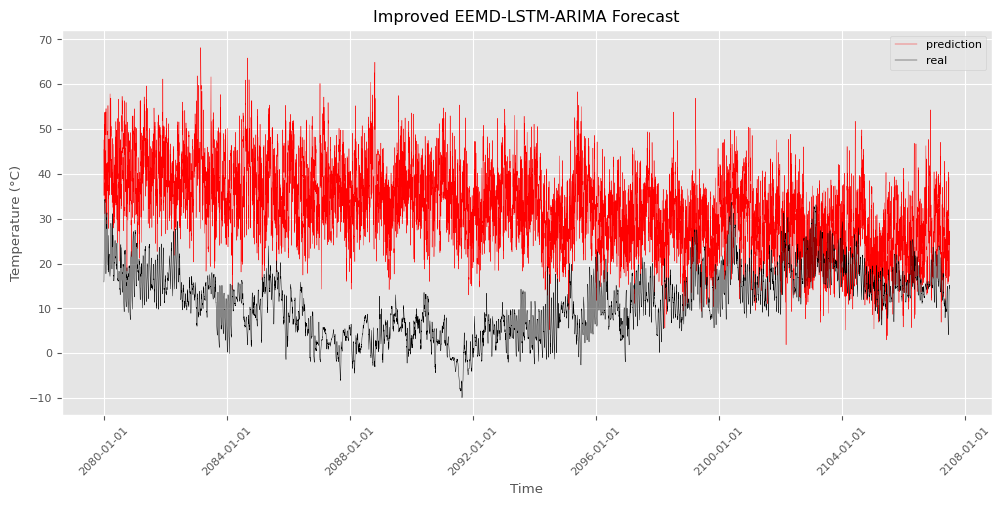

In [35]:
import matplotlib.dates as mdates

train = load[:int(len(load) * 0.8)]
test = load[int(len(load) * 0.8):]

train.index = df.index[:int(len(load) * 0.8)]
test.index = df.index[int(len(load) * 0.8):]

x_label = 'Time'
y_label = 'Temperature (°C)'

plt.figure(figsize=(12, 5))
plt.plot(test.index, imf_eemd_fc + res1.x[0], label='prediction', color='r', linewidth=0.3)
plt.plot(test.index, test.values, label='real', color='k', linewidth=0.3)
plt.xlabel(xlabel=x_label)
plt.ylabel(ylabel=y_label)
plt.title('Improved EEMD-LSTM-ARIMA Forecast')
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.show()

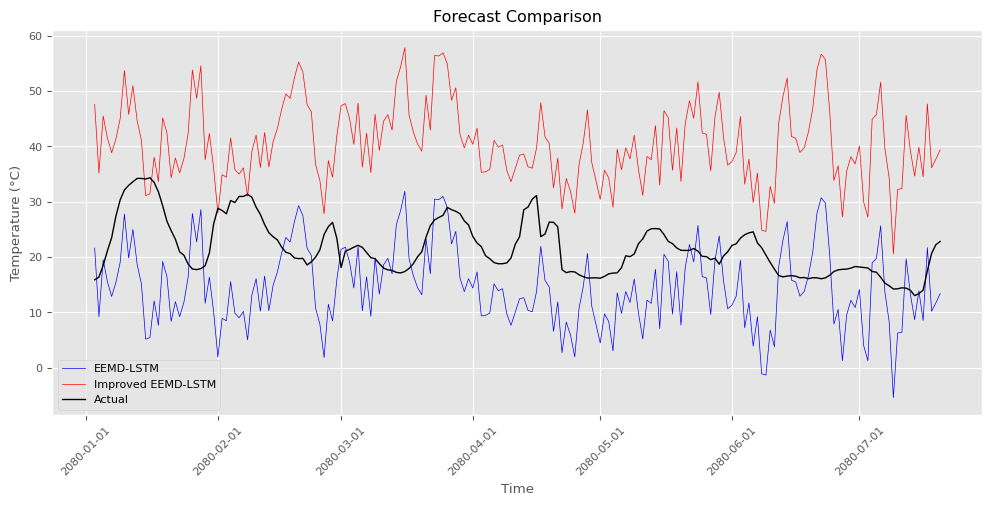

In [36]:
import matplotlib.dates as mdates

train = load[:int(len(load) * 0.8)]
test = load[int(len(load) * 0.8):]

train.index = df.index[:int(len(load) * 0.8)]
test.index = df.index[int(len(load) * 0.8):]

plt.figure(figsize=(12, 5))
plt.plot(test.index[:200], imf_eemd_fc[:200], label='EEMD-LSTM', color='b', linewidth=0.5)
plt.plot(test.index[:200], imf_eemd_fc[:200] + res1.x[0], label='Improved EEMD-LSTM', color='r', linewidth=0.5)
plt.plot(test.index[:200], test.values[:200], label='Actual', color='k', linewidth=1)
plt.title('Forecast Comparison')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.show()